In [6]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from mvl import genData
from torch import tensor

liabParams55cov = genData.genParams(pis=tensor([.1, .1, .05]), rrMeans=tensor([3., 2.]), afMean = tensor(1e-4), pDs = tensor([.01, .01]), afShape=tensor(50.), nCases=tensor([1.5e4, 1.5e4, 4e3]), nCtrls=tensor(5e4), covShared=tensor([ [1, .95], [.95, 1] ]), meanEffectCovarianceScale=tensor(.01))[0]
liabParams55cov["pDs"] = liabParams55cov["pDs"][0:2]
liabData55cov = genData.v6liability(**liabParams55cov)
liabParams55cov["pDs"] = liabData55cov["PDs"] #TODO: normalized names, and indicate that the params pDs are incomplete

covShared tensor([[1.0000, 0.9500],
        [0.9500, 1.0000]])
residualCovariance tensor([[1, 0],
        [0, 1]])
PD1 threshold, PD2 threshold tensor(-2.3263) tensor(-2.3263)
pDsWithBoth tensor([0.0100, 0.0100, 0.0067], dtype=torch.float64)
pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0300, 0.0200])
pdvthresh tensor([1.8808, 2.0537])
meanEffect tensor([0.4456, 0.2726])
meanEffectsAcrossAllGenes tensor([0.4456, 0.2726])
allEffects tensor([[-0.6459, -0.5006],
        [-0.4183, -0.2909],
        [-0.5591, -0.3571],
        ...,
        [-0.6837, -0.4803],
        [-0.4360, -0.2539],
        [-0.5252, -0.3244]])
PD1GivenV.mean() tensor(0.0306) PD2GivenV.mean() tensor(0.0204)
allEffects[i] tensor([-0.6459, -0.5006])
PDBothGivenV.mean tensor(0.0171, dtype=torch.float64)
PDBothGivenV / PDBoth tensor(2.5495, dtype=torch.float64)
pdsCovarOnMean.mean(0) tensor([0.0306, 0.0204, 0.0171], dtype=torch.float64)
np.corrcoef(pdvInBoth[:,0], pdvInBoth[:,1])
 [[1.         0.94944494]
 [0.9494449

In [ ]:
liabData55cov["PVDs"][liabData55cov["affectedGenes"][0]].mean(0)

In [5]:
liabData55cov["altCounts"].sum() / ((liabParams55cov["nCases"].sum() + liabParams55cov["nCtrls"])) / 20_000

tensor(0.0001, dtype=torch.float64)

In [130]:
import torch
p_test = tensor([6.8854e-05, 2.0656e-05, 2.0656e-05, 5.5083e-06])
print(p_test.sum())
total_af_mean = 1e-4

mn = td.Multinomial(probs=p_test, total_count= scaled_N)

# OK, so we can recover the exact
print("mn.probs", mn.probs)
print("p_test[0] / mn.probs[0])", tensor(p_test[0] / mn.probs[0], dtype=torch.float64))
print("mn.probs * (p_test[0] / mn.probs[0])", mn.probs * (p_test[0] / mn.probs[0]))
# This works perfectly
print("mn.probs * total_af", mn.probs * total_af)
print("mn.mean", mn.mean)

tensor(0.0001)
mn.probs tensor([0.5952, 0.1786, 0.1786, 0.0476])
p_test[0] / mn.probs[0]) tensor(0.0001, dtype=torch.float64)
mn.probs * (p_test[0] / mn.probs[0]) tensor([5.9524e-05, 1.7857e-05, 1.7857e-05, 4.7619e-06])
mn.probs * total_af tensor([6.3168e-05, 1.8950e-05, 1.8950e-05, 5.0534e-06])
mn.mean tensor([2.9762, 0.8929, 0.8929, 0.2381])


In [219]:
test_probs = tensor([.0005, .0006, .0002])
print(test_probs.sum())
# 3.89 is .0005 / the actual probability in position 1
# .0005/.3846 == .0013
# This is also the test_probs sum
td.Multinomial(probs=tensor([.0005, .0006, .0002]), total_count= scaled_N).probs * test_probs.sum()

tensor(0.0013)


tensor([0.0005, 0.0006, 0.0002])

In [74]:
td.Multinomial(probs=p_test, total_count= scaled_N).param_shape

torch.Size([4])

In [3]:
liabParams55cov["pDs"]

tensor([0.0100, 0.0100, 0.0067], dtype=torch.float64)

In [9]:
liabParams55cov["pDsample"]

KeyError: 'pDsample'

In [ ]:
def max_k(k_sample_categories: int, max_number_coincident):
    mk = k_sample_categories


In [18]:
import numpyro
from numpyro.distributions import Multinomial, Beta, Dirichlet, DirichletMultinomial, Gamma, Beta, Categorical, Uniform, MultivariateNormal, Normal, LogNormal, Exponential, HalfCauchy, LKJCholesky
from jax import random
from numpyro.infer import MCMC, NUTS, SA, Predictive
import numpy as np
import jax.numpy as jnp
import jax

numpyro.set_host_device_count(6)
numpyro.enable_x64()

def mix_weights(beta: jnp.array):
    beta_cumprod = (1 - beta).cumprod(-1)
    return jnp.pad(beta, (0,1), constant_values=1) * jnp.pad(beta_cumprod, (1,0), constant_values = 1)


# mu_exp, var_exp = get_log_params(liabParams55cov["afMean"].numpy(), 1)
# Expected number of components
# For 2 case types it's
# none, 1only, 2only, both
# For 3 it's
# none, 1only, 2only, 3only, 1&2, 1&3, 2&3, 123 (7)
# for 4 it's
# none, 1only, 2only, 3only, 4only, 1&2, 1&3, 1&4, 2&3, 2&4, 3&4, 123, 124, 134, 234, 1234
# which is 4 + 4choose2 + nchoose3  + nchoose4 
nHypotheses = 6
kConditions = 4
altCounts = liabData55cov["altCounts"].numpy()
N = len(liabData55cov["altCounts"])

nCases = liabParams55cov["nCases"].numpy()
nCtrls = liabParams55cov["nCtrls"].numpy()
empiricalAfs = altCounts.sum(1) / (nCases.sum() + nCtrls)
print("empirical afs", altCounts / (nCases.sum() + nCtrls))
samplePDs = nCases / (nCases.sum() + nCtrls)
pdsAll = np.array([1 - samplePDs.sum(), *samplePDs])
print("pdsAll", pdsAll)

# TODO: do this in numpy natively
pdsAllShaped = jnp.asarray(tensor(pdsAll).expand(nHypotheses, kConditions).numpy())
pdsAllnp = [1 - samplePDs.sum(), *samplePDs]
pdsAll = jnp.asarray([1 - samplePDs.sum(), *samplePDs])
print(pdsAllShaped)
print(pdsAll.shape)
print((1/pdsAll).shape)
alpha = .01
print("nHypotheses", nHypotheses)

### Cases1 # Cases2 # CasesBOth
#G1 10.       0.      5
#G2 .. 

exponential_prior = jnp.array([.01]).repeat(kConditions)
# exponential_prior_broadcast = np.broadcast_to(np.array([[empiricalAfs]]).T, (20_000, 6, 4))
def model(data):
    # If in pyro: conc = numpyro.sample('conc', Exponential(exponential_prior).to_event(1))

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha))

    with numpyro.plate("prob_plate", nHypotheses):
        conc = numpyro.sample('conc', Exponential(exponential_prior).to_event(1))
        probs = numpyro.sample("probs", Dirichlet(conc)) * pdsAll

    with numpyro.plate("data", data.shape[0]):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def model2(data):
    # If in pyro: conc = numpyro.sample('conc', Exponential(exponential_prior).to_event(1))

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha))

    with numpyro.plate("prob_plate", nHypotheses):
        # conc = numpyro.sample('conc', Gamma(np.ones(pdsAllShaped.shape) / nHypotheses, 1).to_event(1))
        probs = numpyro.sample("probs", Dirichlet(pdsAll))

    with numpyro.plate("data", data.shape[0]):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        print("z.shape", z.shape)
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def modelGamma(data):
    # This also works, for a single set of shraed parameters
    # with numpyro.plate("conc_plate", 1):
    #     conc = numpyro.sample('conc', Exponential(.001))

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha))

    with numpyro.plate("prob_plate", nHypotheses):
        conc = numpyro.sample('conc', Gamma(np.ones(pdsAllShaped.shape) / nHypotheses, 1).to_event(1))
        probs = numpyro.sample("probs", Dirichlet(conc)) * pdsAllShaped

    with numpyro.plate("data", data.shape[0]):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def modelGamma2(data):
    # This also works, for a single set of shraed parameters
    # with numpyro.plate("conc_plate", 1):
    #     conc = numpyro.sample('conc', Exponential(.001))

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha))

    with numpyro.plate("prob_plate", nHypotheses):
        conc = numpyro.sample('conc', Gamma(np.ones(pdsAllShaped.shape) / nHypotheses, 1).to_event(1))
        probs = numpyro.sample("probs", Dirichlet(conc)) * pdsAllShaped

    with numpyro.plate("data", data.shape[0]):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def modelUniform(data):
    # This also works, for a single set of shraed parameters
    # with numpyro.plate("conc_plate", 1):
    #     conc = numpyro.sample('conc', Exponential(.001))

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha))

    with numpyro.plate("prob_plate", nHypotheses):
        conc = numpyro.sample('conc', Uniform(np.ones(kConditions), 25000).to_event(1))
        probs = numpyro.sample("probs", Dirichlet(conc)) * pdsAll

    with numpyro.plate("data", N):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def modelSimple(data):
    # This also works, for a single set of shraed parameters
    # with numpyro.plate("conc_plate", 1):
    #     conc = numpyro.sample('conc', Exponential(.001))

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha))

    with numpyro.plate("prob_plate", nHypotheses):
        # conc = numpyro.sample('conc', Uniform(np.ones(kConditions), 25000).to_event(1))
        probs = numpyro.sample("probs", Dirichlet(pdsAll))

    with numpyro.plate("data", N):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        # print("probs[z]", probs[z])
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

# super slow
# def modelSimple(data):
#     with numpyro.plate("beta_plate", nHypotheses-1):
#         beta = numpyro.sample("beta", Beta(1, alpha))

#     with numpyro.plate("prob_plate", nHypotheses):
#         conc = numpyro.sample('conc', Gamma(pdsAllShaped, 1).to_event(1))

#     with numpyro.plate("data", N):
#         z = numpyro.sample("z", Categorical(mix_weights(beta)))
#         return numpyro.sample("obs", DirichletMultinomial(concentration=conc[z]), obs=data)

def model1(data):
    # This also works, for a single set of shraed parameters
    with numpyro.plate("conc_plate", kConditions):
        conc = numpyro.sample('conc', Exponential(.01, validate_args=False))

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha, validate_args=False))

    with numpyro.plate("prob_plate", nHypotheses):
        probs = numpyro.sample("probs", Dirichlet(conc, validate_args=False)) * pdsAll

    with numpyro.plate("data", N):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z], validate_args=False), obs=data)

# This works, is fairly fast (6-10it/s)
print("pdsAllShaped", pdsAllShaped)
def modelPartialPooledNoMix(data):
    # This also works, for a single set of shraed parameters
    conc = numpyro.sample("conc", Gamma(pdsAllShaped, 1))
    # print("conc.shape", conc)
    # with numpyro.plate("beta_plate", nHypotheses):
    #     beta = numpyro.sample("beta", Beta(1, alpha, validate_args=False))
    for i in range(nHypotheses):
        probs = numpyro.sample(f"probs_{i}", Dirichlet(conc[i], validate_args=False)) * pdsAll

    with numpyro.plate("data", N):
        # print("conc[0].shape", conc[0].shape)
        # z = numpyro.sample("z", Categorical(mix_weights(beta)))
        # probs = numpyro.sample("probs", Dirichlet(conc[0], validate_args=False))
        return numpyro.sample("obs", Multinomial(probs=probs, validate_args=False), obs=data)

# This works
def modelPartialPooledWithDP(data):
    # This also works, for a single set of shraed parameters
    # print("conc.shape", conc)
    with numpyro.plate("beta_plate", nHypotheses - 1):
        beta = numpyro.sample("beta", Beta(1, alpha, validate_args=False))
    # for i in range(nHypotheses):
    #     probs = numpyro.sample(f"probs_{i}", Dirichlet(conc[i], validate_args=False)) * pdsAll
    conc = numpyro.sample("conc", Gamma(pdsAllShaped, 1))

    with numpyro.plate("data", N):
        # print("conc[0].shape", conc[0].shape)
        # z = numpyro.sample("z", Categorical(mix_weights(beta)))
        # probs = numpyro.sample("probs", Dirichlet(conc[0], validate_args=False))
        return numpyro.sample("obs", Multinomial(probs=np.eye(1), validate_args=False), obs=data)

# breaks, the stack error
def modelPartialPooledDPError(data):
    # This also works, for a single set of shraed parameters
    # print("conc.shape", conc)
    with numpyro.plate("beta_plate", nHypotheses - 1):
        beta = numpyro.sample("beta", Beta(1, alpha, validate_args=False))
    # for i in range(nHypotheses):
    #     probs = numpyro.sample(f"probs_{i}", Dirichlet(conc[i], validate_args=False)) * pdsAll
    conc = numpyro.sample("conc", Gamma(pdsAllShaped, 1))

    with numpyro.plate("data", N):
        # print("conc[0].shape", conc[0].shape)
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        # probs = numpyro.sample("probs", Dirichlet(conc[0], validate_args=False))
        return numpyro.sample("obs", Multinomial(probs=np.eye(1), validate_args=False), obs=data)


def modelLogNormal(data):
    # with numpyro.plate("prob_plate", kConditions):
    #      # Vector of variances for each of the d variables
    #     theta = numpyro.sample("theta", HalfCauchy(jnp.ones(kConditions)).to_event(1))
    #     print("theta", theta)
    #     # Lower cholesky factor of a correlation matrix
    #     eta = jnp.ones(1)  # Implies a uniform distribution over correlation matrices
    #     L_omega = numpyro.sample("L_omega", LKJCholesky(kConditions, eta))
    #     # Lower cholesky factor of the covariance matrix
    #     L_Omega = jnp.matmul(jnp.diag(jnp.sqrt(theta)), L_omega)
    #     print("L_Omega", L_Omega)
    # For inference with SVI, one might prefer to use torch.bmm(theta.sqrt().diag_embed(), L_omega)

        # Vector of expectations
        # mu = jnp.zeros(kConditions)
        # print("L_Omega", L_Omega, L_Omega.shape)

    with numpyro.plate("beta_plate", nHypotheses-1):
        beta = numpyro.sample("beta", Beta(1, alpha))

    with numpyro.plate("prob_plate", nHypotheses):
        # print("pdsAll", pdsAll)
        # theta = numpyro.sample("theta", HalfCauchy(jnp.ones(kConditions)).to_event(1))
        # print("theta", theta)
        # Lower cholesky factor of a correlation matrix
        # eta = jnp.ones(1)  # Implies a uniform distribution over correlation matrices
        # L_omega = numpyro.sample("L_omega", LKJCholesky(kConditions, eta))
        # Lower cholesky factor of the covariance matrix
        # L_Omega = jnp.matmul(jnp.diag(jnp.sqrt(theta)), L_omega)
        # print("L_Omega", L_Omega)
    # For inference with SVI, one might pr
        probs = jax.nn.softmax(numpyro.sample("probs", MultivariateNormal(pdsAll, jnp.eye(kConditions) ) ) )

    with numpyro.plate("data", N):
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        return numpyro.sample("obs", Multinomial(probs=probs[z]), obs=data)

def get_posterior_samples(mcmc):
    posterior_samples = mcmc.get_samples()
    posterior_samples['pi'] = stickbreak(posterior_samples['beta'])
    
    return posterior_samples

empirical afs [[8.33333333e-05 3.57142857e-05 0.00000000e+00 3.57142857e-05]
 [3.57142857e-05 2.38095238e-05 2.38095238e-05 0.00000000e+00]
 [8.33333333e-05 0.00000000e+00 3.57142857e-05 1.19047619e-05]
 ...
 [1.19047619e-05 5.95238095e-05 2.38095238e-05 4.76190476e-05]
 [5.95238095e-05 1.19047619e-05 2.38095238e-05 0.00000000e+00]
 [4.76190476e-05 9.52380952e-05 0.00000000e+00 0.00000000e+00]]
pdsAll [0.59523809 0.17857143 0.17857143 0.04761905]
[[0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]]
(4,)
(4,)
nHypotheses 6
pdsAllShaped [[0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.0476

In [4]:
import numpyro
from numpyro.distributions import Multinomial, Beta, Dirichlet, DirichletMultinomial, Gamma, Beta, Categorical, Uniform, MultivariateNormal, Normal, LogNormal, Exponential, HalfCauchy, LKJCholesky
from jax import random
from numpyro.infer import MCMC, NUTS, SA, Predictive
import numpy as np
import jax.numpy as jnp
import jax

numpyro.set_host_device_count(6)
numpyro.enable_x64()

def mix_weights(beta: jnp.array):
    beta_cumprod = (1 - beta).cumprod(-1)
    return jnp.pad(beta, (0,1), constant_values=1) * jnp.pad(beta_cumprod, (1,0), constant_values = 1)


# mu_exp, var_exp = get_log_params(liabParams55cov["afMean"].numpy(), 1)
# Expected number of components
# For 2 case types it's
# none, 1only, 2only, both
# For 3 it's
# none, 1only, 2only, 3only, 1&2, 1&3, 2&3, 123 (7)
# for 4 it's
# none, 1only, 2only, 3only, 4only, 1&2, 1&3, 1&4, 2&3, 2&4, 3&4, 123, 124, 134, 234, 1234
# which is 4 + 4choose2 + nchoose3  + nchoose4 
nHypotheses = 6
kConditions = 4
altCounts = liabData55cov["altCounts"].numpy()
N = len(liabData55cov["altCounts"])

nCases = liabParams55cov["nCases"].numpy()
nCtrls = liabParams55cov["nCtrls"].numpy()
empiricalAfs = altCounts.sum(1) / (nCases.sum() + nCtrls)
print("empirical afs", altCounts / (nCases.sum() + nCtrls))
samplePDs = nCases / (nCases.sum() + nCtrls)
pdsAll = np.array([1 - samplePDs.sum(), *samplePDs])
print("pdsAll", pdsAll)

# TODO: do this in numpy natively
pdsAllShaped = jnp.asarray(tensor(pdsAll).expand(nHypotheses, kConditions).numpy())
pdsAllnp = [1 - samplePDs.sum(), *samplePDs]
pdsAll = jnp.asarray([1 - samplePDs.sum(), *samplePDs])
print(pdsAllShaped)
print(pdsAll.shape)
print((1/pdsAll).shape)
alpha = .01
print("nHypotheses", nHypotheses)


# For variational inference in pyro you're drawing reparameterized samples, and those ignore independence
# For inference is most interesting for discrete random variables

# It's computationally expensive if something outside of a plate depends on something inside of a plate
# You shouldn't have any arrows pointing out of a plate, to minimize performance

# architecture1 priors
# architecture2 priors
def modelPartialPooled(data):
    # This also works, for a single set of shraed parameters
    # print("conc.shape", conc)
    #with numpyro.plate("beta_plate", nHypotheses - 1):
    beta = numpyro.sample("beta3", Beta(np.ones(nHypotheses-1), alpha, validate_args=False).to_event(1))
    # for i in range(nHypotheses):
    #     probs = numpyro.sample(f"probs_{i}", Dirichlet(conc[i], validate_args=False)) * pdsAll
    # pi = numpyro.sample("pi", dist.Dirichlet(jnp.ones(num_classes)))
    conc = numpyro.sample("conc", Gamma(pdsAllShaped, 1).to_event(2))
    conc ~ XB + e
    with numpyro.plate("data", N):
        # conc ~ XB + e
        z = numpyro.sample("z", Categorical(mix_weights(beta)))
        component_conc = conc[z]
        # nCaseCategories x 1
        component_conc ~ XB + e

        # We may be able with numpyro.plate('samples', S):
        # probs = numpyro.sample("probs", Dirichlet(conc[z], validate_args=False))
        return numpyro.sample("obs", Multinomial(probs=e, validate_args=False), obs=data)


empirical afs [[5.95238095e-05 0.00000000e+00 0.00000000e+00 1.19047619e-05]
 [7.14285714e-05 1.19047619e-05 1.19047619e-05 0.00000000e+00]
 [5.95238095e-05 2.38095238e-05 0.00000000e+00 0.00000000e+00]
 ...
 [3.57142857e-05 3.57142857e-05 0.00000000e+00 1.19047619e-05]
 [3.57142857e-05 3.57142857e-05 1.19047619e-05 1.19047619e-05]
 [5.95238095e-05 2.38095238e-05 0.00000000e+00 0.00000000e+00]]
pdsAll [0.59523809 0.17857143 0.17857143 0.04761905]
[[0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]
 [0.59523809 0.17857143 0.17857143 0.04761905]]
(4,)
(4,)
nHypotheses 6


In [3]:
init_rng_key = random.PRNGKey(12273)
mcmcPP = MCMC(NUTS(modelPartialPooled), 100, 1000)
mcmcPP.run(init_rng_key, altCounts)
mcmcPP.print_summary()

warmup:   1%|          | 7/1100 [00:58<2:31:49,  8.33s/it, 1023 steps of size 2.76e-03. acc. prob=0.42]


KeyboardInterrupt: 

In [158]:
altCounts

array([[6., 1., 2., 1.],
       [6., 0., 1., 0.],
       [7., 0., 1., 0.],
       ...,
       [6., 1., 2., 2.],
       [4., 2., 0., 0.],
       [7., 0., 1., 0.]])

In [153]:
Gamma(pdsAllShaped, 1).sample(init_rng_key).shape

(6, 4)

In [144]:
def plot_param_post(params, param_name, param_full_name, figsize=(12, 4),
                    truth=None, plot_trace=True):
    if plot_trace:
        plt.figure(figsize=figsize)
        
    param = params[param_name]

    if plot_trace:
        plt.subplot(1, 2, 1)
        
    plt.boxplot(param.T, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    if plot_trace:
        plt.subplot(1, 2, 2)
        plt.plot(param)
        plt.xlabel('iterations')
        plt.ylabel(param_full_name)
        plt.title('Trace plot of {}'.format(param_full_name))


Text(0.5, 1.0, 'Negative ELBO')

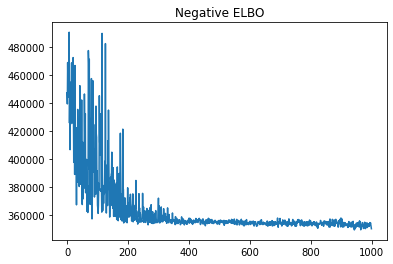

In [140]:
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, ELBO
from jax import random, lax
import matplotlib.pyplot as plt


guide = AutoMultivariateNormal(model2)
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(guide.model, guide, optimizer, loss=ELBO())
init_state = svi.init(random.PRNGKey(2), altCounts)


# Run optimizer
state, losses = lax.scan(lambda state, i: svi.update(state, altCounts), init_state, np.arange(1000))

def sample_advi_posterior(guide, params, nsamples, seed=1):
    samples = guide.get_posterior(params).sample(random.PRNGKey(seed), (nsamples, ))
    # NOTE: Samples are arranged in alphabetical order.
    #       Not in the order in which they appear in the
    #       model. This is different from pyro.
    return samples

# Extract surrogate posterior.
params = svi.get_params(state)
plt.plot(losses)
plt.title("Negative ELBO")
# advi_samples = sample_advi_posterior(guide, params, nsamples=500, seed=1)


In [141]:
params=svi.get_params(state)
params

{'auto_loc': DeviceArray([-1.15098815,  1.62395578, -1.92398359,  0.71576841,
               1.8743358 , -1.16763645, -0.60285989, -0.7717677 ,
              -0.44283444, -1.14673878, -0.74765658, -0.72510078,
              -0.52885625, -0.99980787, -0.74349247, -0.73618718,
              -0.35340657, -1.15620953, -0.76707259, -0.83601796,
              -0.5077969 , -1.13191734, -0.72516398, -0.76416093,
              -0.6007157 , -1.10535486, -0.82651946, -0.88884154,
              -0.39384757,  1.23397211,  0.55342502,  1.13451951,
               1.24279958,  0.5624475 ,  1.12991399,  1.19779081,
               0.54379372,  1.14038542,  1.21529392,  0.54948667,
               1.14386752,  1.2355253 ,  0.54883767,  1.13359562,
               1.20473615,  0.56968241,  1.03140134], dtype=float64),
 'auto_scale_tril': DeviceArray([[ 0.3462334 ,  0.        ,  0.        , ...,  0.        ,
                0.        ,  0.        ],
              [ 0.08575807,  0.23826298,  0.        , ..., 

In [124]:
prior = Predictive(model2, num_samples=int(1e4))(
    random.PRNGKey(1999), data=np.zeros(6))

In [126]:
prior["probs"].mean(0)

DeviceArray([[0.37774902, 0.24687326, 0.23705687, 0.13832086],
             [0.37526457, 0.24655131, 0.24010604, 0.13807808],
             [0.37648676, 0.24281034, 0.24369386, 0.13700904],
             [0.37762328, 0.24547783, 0.24122438, 0.13567451],
             [0.38074594, 0.24483805, 0.2390636 , 0.13535241],
             [0.37798377, 0.24209539, 0.23604866, 0.14387217]],            dtype=float64)

In [136]:
pdsAll

DeviceArray([0.59523809, 0.17857143, 0.17857143, 0.04761905], dtype=float64)

In [70]:
(plt.figure(figsize=(12, 12))

# plt.subplot(2, 2, 1)
# plot_param_post(advi_samples, 'beta', "beta", plot_trace=False)
plt.hist(advi_samples['beta'], bins=30, density=True); plt.title("Histogram of betas")


# plt.subplot(2, 2, 2)
plt.hist(advi_samples['probs'], bins=30, density=True); plt.title("Histogram of probs")
# plt.subplot(2, 2, 3)
# plt.tight_layout()

IndexError: Too many indices for array: 4 non-None/Ellipsis indices for dim 2.

In [71]:
advi_samples

DeviceArray([[-1.4422969 ,  2.61034526, -1.97092102, ...,  1.22502182,
               0.50388113,  1.23520785],
             [-1.63336123,  1.43674827, -0.43659316, ...,  1.26519708,
               0.5422426 ,  1.19320467],
             [-1.21345276,  2.84651594, -4.00882816, ...,  1.22841966,
               0.68494358,  1.30967938],
             ...,
             [-1.50402104,  2.69812278,  1.53350925, ...,  1.23863302,
               0.44505614,  0.90587505],
             [-1.35226457,  2.03887513, -1.63597117, ...,  1.23297896,
               0.48248359,  1.36685426],
             [-1.39405363,  1.86790175, -1.96038896, ...,  1.20075629,
               0.48044188,  1.17793504]], dtype=float64)

In [148]:
init_rng_key = random.PRNGKey(12273)
mcmc2 = MCMC(NUTS(model2), 100, 1000)
mcmc2.run(init_rng_key, altCounts)
mcmc2.print_summary()

z.shape (20000,)
z.shape (6, 1)
  0%|          | 0/1100 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [145]:
init_rng_key = random.PRNGKey(12273)
mcmc2 = MCMC(NUTS(model2), 100, 1000)
mcmc2.run(init_rng_key, altCounts)
mcmc2.print_summary()

sample: 100%|██████████| 1100/1100 [36:24<00:00,  1.99s/it, 511 steps of size 1.30e-02. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.12      0.02      0.12      0.09      0.15    974.10      1.00
   beta[1]      0.12      0.02      0.12      0.08      0.16    673.43      1.00
   beta[2]      0.88      0.03      0.88      0.84      0.93   1070.36      1.00
   beta[3]      1.00      0.00      1.00      1.00      1.00    954.84      1.00
   beta[4]      0.98      0.10      1.00      0.96      1.00    866.41      1.00
probs[0,0]      0.39      0.01      0.39      0.38      0.40   1183.73      1.00
probs[0,1]      0.39      0.01      0.39      0.37      0.40   1217.92      1.00
probs[0,2]      0.11      0.01      0.11      0.10      0.13    962.83      1.00
probs[0,3]      0.11      0.00      0.11      0.10      0.12   1074.96      1.00
probs[1,0]      0.47      0.02      0.47      0.44      0.49    883.83      1.00
prob

In [146]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
prob2 = mcmc2.get_samples()["probs"]
print(prob2.mean(0))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaled2 = mcmc2.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaled2).mean(0))

[[0.39211874 0.38736612 0.11190081 0.10861433]
 [0.46612388 0.11838287 0.32745656 0.08803669]
 [0.60266295 0.17639223 0.17521274 0.04573208]
 [0.3535165  0.33476523 0.24628394 0.06543433]
 [0.61430071 0.17304907 0.15526492 0.0573853 ]
 [0.59373944 0.18928602 0.1709757  0.04599884]]
inferred stick-breaking weights [0.12254736 0.10393912 0.68339908 0.09331336 0.00106234 0.00099934]


In [4]:
init_rng_key = random.PRNGKey(12273)
mcmcGamma = MCMC(NUTS(modelGamma), 100, 1000)
mcmcGamma.run(init_rng_key, altCounts)
mcmcGamma.print_summary()

conc [[2.00129591 3.21089628 0.24526678 0.22278495]
 [5.26640257 0.1694261  0.52994417 0.20110634]
 [2.34816385 7.35517131 1.24963289 0.38134861]
 [0.42218231 3.41799151 2.45515856 0.26877573]
 [0.7501398  3.71328    0.31491819 0.16714328]
 [0.89264173 0.20535182 0.76651087 1.3324808 ]]
z [0 1 0 ... 0 0 0]
conc [[2.00129591 3.21089628 0.24526678 0.22278495]
 [5.26640257 0.1694261  0.52994417 0.20110634]
 [2.34816385 7.35517131 1.24963289 0.38134861]
 [0.42218231 3.41799151 2.45515856 0.26877573]
 [0.7501398  3.71328    0.31491819 0.16714328]
 [0.89264173 0.20535182 0.76651087 1.3324808 ]]
conc Traced<ConcreteArray([[4.54624576 5.61589118 4.68512146 2.09159227]
 [3.31563156 0.92769964 0.15529629 0.38757781]
 [5.93219306 3.99363856 3.79682384 3.22168162]
 [1.17839928 0.62780711 1.43231853 0.24220532]
 [6.1643545  0.28355383 0.29489148 7.29163739]
 [5.55883343 0.18768693 2.78877944 2.73324332]])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([[4.54624576, 5.61589118, 4.68512146, 2.

AssertionError: 

In [36]:
init_rng_key = random.PRNGKey(12273)
mcmcSimple = MCMC(NUTS(modelSimple), 100, 1000)
mcmcSimple.run(init_rng_key, altCounts)
mcmcSimple.print_summary()

sample:  27%|██▋       | 296/1100 [17:02<46:16,  3.45s/it, 511 steps of size 7.43e-03. acc. prob=0.94]


KeyboardInterrupt: 

In [35]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
probsSimple = mcmcSimple.get_samples()["probs"]
print(probsSimple.mean(0))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledSimple = mcmcSimple.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledSimple).mean(0))

[[0.5041468  0.02962807 0.3695263  0.09669884]
 [0.56632585 0.2954333  0.10135369 0.03688717]
 [0.59083704 0.17382153 0.19808393 0.0372575 ]
 [0.60589801 0.18068432 0.16405865 0.04935902]
 [0.35699295 0.45567841 0.08749574 0.0998329 ]
 [0.35487096 0.26203966 0.25122767 0.13186171]]
inferred stick-breaking weights [0.05660541 0.06997263 0.44263237 0.22393389 0.06310229 0.1476791 ]


In [40]:
init_rng_key = random.PRNGKey(12273)
mcmcSimple = MCMC(SA(modelSimple), 10000, 1000)
mcmcSimple.run(init_rng_key, altCounts)
mcmcSimple.print_summary()

sample: 100%|██████████| 11000/11000 [01:11<00:00, 153.24it/s, acc. prob=0.44]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.02      0.00      0.02      0.02      0.03    931.12      1.01
   beta[1]      0.05      0.00      0.05      0.05      0.06    745.51      1.01
   beta[2]      0.56      0.01      0.56      0.54      0.58   1017.82      1.01
   beta[3]      0.57      0.02      0.57      0.54      0.59    415.82      1.03
   beta[4]      0.31      0.02      0.31      0.28      0.35    294.28      1.04
probs[0,0]      0.43      0.01      0.43      0.40      0.45   1002.19      1.00
probs[0,1]      0.03      0.00      0.03      0.02      0.03    693.51      1.02
probs[0,2]      0.46      0.01      0.46      0.44      0.48   1021.61      1.00
probs[0,3]      0.09      0.01      0.08      0.08      0.09     98.94      1.05
probs[1,0]      0.51      0.01      0.50      0.49      0.52    849.28      1.00
probs[1,1]      0.35      0.0

In [45]:
init_rng_key = random.PRNGKey(12273)
mcmcLN = MCMC(SA(modelLogNormal), 10000, 1000)
mcmcLN.run(init_rng_key, altCounts)
mcmcLN.print_summary()

sample: 100%|██████████| 11000/11000 [01:13<00:00, 149.06it/s, acc. prob=0.35]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.58      0.01      0.58      0.57      0.59    899.19      1.00
   beta[1]      0.51      0.00      0.51      0.50      0.51    988.83      1.00
   beta[2]      0.76      0.01      0.76      0.75      0.78    843.65      1.00
   beta[3]      0.05      0.00      0.05      0.04      0.05    926.02      1.00
   beta[4]      0.14      0.01      0.14      0.12      0.15    975.57      1.00
probs[0,0]      3.56      0.06      3.56      3.48      3.66    876.21      1.00
probs[0,1]      2.41      0.06      2.41      2.33      2.50    934.35      1.00
probs[0,2]      2.32      0.05      2.31      2.24      2.40    960.74      1.00
probs[0,3]      0.85      0.06      0.85      0.77      0.95    893.67      1.01
probs[1,0]      0.42      0.05      0.42      0.34      0.49    971.23      1.00
probs[1,1]      0.31      0.0

In [46]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
sLN = mcmcLN.get_samples()["probs"]
print(sLN.mean(0))
print("jax.nn.softmax", jax.nn.softmax(sLN.mean(0)))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledLNInDirichlet = mcmcLN.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledLNInDirichlet).mean(0))

[[ 3.56192564  2.40868739  2.31756464  0.84996852]
 [ 0.4228688   0.31410312 -0.76018548 -1.05087126]
 [ 1.67232722  1.04500591  1.48405276  0.52863318]
 [-1.04289892  1.24048844  1.39878777 -0.54816687]
 [-0.72541821 -1.04325559 -1.5495451   2.54201477]
 [ 2.88233587 -4.43927131  2.23721252  0.73308379]]
jax.nn.softmax [[5.98750496e-01 1.88973487e-01 1.72514964e-01 3.97610527e-02]
 [4.11125149e-01 3.68754824e-01 1.25944758e-01 9.41752687e-02]
 [3.72988550e-01 1.99183480e-01 3.08978982e-01 1.18848988e-01]
 [4.17670448e-02 4.09728603e-01 4.80003946e-01 6.85004069e-02]
 [3.51985973e-02 2.56147627e-02 1.54387308e-02 9.23747909e-01]
 [6.09076369e-01 4.02659688e-04 3.19520141e-01 7.10008309e-02]]
inferred stick-breaking weights [0.58231283 0.21231627 0.15820455 0.00239424 0.00662319 0.04092723]


In [41]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
probsSimple = mcmcSimple.get_samples()["probs"]
print(probsSimple.mean(0))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledSimple = mcmcSimple.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledSimple).mean(0))

[[0.42678979 0.02754298 0.46027648 0.08539075]
 [0.50566229 0.3477675  0.11600847 0.03056174]
 [0.56838335 0.1777707  0.19770722 0.05613874]
 [0.6479463  0.1487683  0.16870133 0.03458407]
 [0.38695041 0.42500013 0.07910907 0.10894039]
 [0.33833094 0.30838519 0.2354203  0.11786357]]
inferred stick-breaking weights [0.02483603 0.05040959 0.5234615  0.23114903 0.05410037 0.12006325]


In [25]:
init_rng_key = random.PRNGKey(12273)
mcmc = MCMC(NUTS(model), 100, 1000)
mcmc.run(init_rng_key, altCounts)
mcmc.print_summary()

sample:  53%|█████▎    | 581/1100 [20:32<18:20,  2.12s/it, 511 steps of size 9.73e-03. acc. prob=0.95]


KeyboardInterrupt: 

In [14]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
probs = mcmc.get_samples()["probs"]
print(probs.mean(0))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaled = mcmcSimple.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaled).mean(0))

[[0.35755394 0.32762857 0.23290327 0.08191422]
 [0.48924372 0.11289133 0.31789706 0.07996788]
 [0.60314798 0.17777806 0.17273039 0.04634357]
 [0.38183901 0.40092201 0.10283599 0.11440299]
 [0.25277387 0.26271651 0.25232567 0.23218395]
 [0.25751675 0.23329801 0.24665294 0.26253229]]
inferred stick-breaking weights [0.10060252 0.10562803 0.70271276 0.0943362  0.00104557 0.00099948]


In [12]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
probsSimple = mcmcSimple.get_samples()["probs"]
print(probsSimple.mean(0))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledSimple = mcmcSimple.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledSimple).mean(0))

[[0.38201752 0.39553869 0.10915769 0.11328611]
 [0.48914713 0.11213708 0.31776914 0.08094665]
 [0.60269817 0.17787539 0.17313951 0.04628693]
 [0.35237301 0.32552174 0.24226577 0.07983947]
 [0.25097589 0.2605425  0.24627794 0.24220367]
 [0.242538   0.24934954 0.25666506 0.25144739]]
inferred stick-breaking weights [0.10060252 0.10562803 0.70271276 0.0943362  0.00104557 0.00099948]


In [287]:
n0 = len(liabData55cov["unaffectedGenes"])
n1 = len(liabData55cov["affectedGenes"][0])
n2 = len(liabData55cov["affectedGenes"][1])
nBoth = len(liabData55cov["affectedGenes"][2])

pisEmpirical = tensor([n0, n1, n2, nBoth]) / tensor(float((n0 + n1 + n2 + nBoth)))
pisEmpirical

tensor([0.7513, 0.0988, 0.0967, 0.0532])

In [24]:
Multinomial?

Signature: Multinomial(total_count=1, probs=None, logits=None, validate_args=None)
Docstring: <no docstring>
File:      ~/miniconda3/lib/python3.7/site-packages/numpyro/distributions/discrete.py
Type:      function


In [ ]:
def fn():
x = nu'mpyro.sample('x', numpyro.distributions.Exponential(.01))
    return x
   
print(numpyro.handlers.seed(fn, rng_seed=2)())

In [ ]:
jnp.eye(kConditions)

In [10]:
]


Requirement already up-to-date: numpyro in /Users/alexkotlar/miniconda3/lib/python3.7/site-packages (0.4.1)
You should consider upgrading via the '/Users/alexkotlar/miniconda3/bin/python3.7 -m pip install --upgrade pip' command.


In [436]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
concGamma = mcmcGamma.get_samples()["conc"]
print("concGamma.mean(0)\n", concGamma.mean(0))
print("\n\nconcGamma.std(0)\n", concGamma.std(0))

probsGamma = mcmcGamma.get_samples()["probs"]
print("\n\nprobsGamma.mean(0)\n",probsGamma.mean(0))
print("\n\nprobsGamma.std(0)\n",probsGamma.std(0))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaGamma = mcmcGamma.get_samples()['beta']
print("\ninferred stick-breaking weights", mix_weights(betaGamma).mean(0))


weights = mix_weights(betaGamma).mean(0)
print("weights", weights)
weightsIdx = np.nonzero(weights >= .01)
print("weightsIdx", weightsIdx)
pisInferred = weights[weightsIdx]
acceptedProbsMean = probsGamma.mean(0)[weightsIdx]
acceptedProbsLastMean = probsGamma[-1][weightsIdx]
print("pisInferred", pisInferred)
print("acceptedProbsMean", acceptedProbsMean)
# print("acceptedProbsLastMean",acceptedProbsLastMean)
# pdv tensor([0.5059, 0.1545, 0.3103, 0.0828], dtype=torch.float64)
# pdv scaled tensor([0.4803, 0.1466, 0.2946, 0.0786], dtype=torch.float64)

concGamma.mean(0)
 [[0.65494114 0.65561657 0.53838603 0.38221167]
 [0.68520563 0.31550789 0.14851645 0.1577748 ]
 [0.85482666 0.47064133 0.4545938  0.31773091]
 [0.7575925  0.41993291 0.67723309 0.4021293 ]
 [0.66957306 0.68627372 0.39678686 0.41167629]
 [0.31235252 0.2639591  0.26612618 0.30457256]]


concGamma.std(0)
 [[0.63519622 0.61511268 0.49677209 0.33767606]
 [0.79755738 0.42319524 0.28107021 0.22554174]
 [0.85234938 0.44780868 0.45026178 0.2837045 ]
 [0.71135739 0.37818191 0.62938568 0.37403074]
 [0.65223208 0.63941684 0.39189112 0.41114372]
 [0.54376414 0.4537137  0.52960361 0.4920807 ]]


probsGamma.mean(0)
 [[0.33718339 0.35768511 0.22262554 0.08250596]
 [0.76555272 0.13935501 0.06607649 0.02901578]
 [0.59965857 0.17078234 0.18181609 0.04774299]
 [0.43680396 0.10901406 0.36306802 0.09111396]
 [0.39701997 0.39050298 0.10364204 0.10883502]
 [0.30967865 0.2178806  0.2297171  0.24272365]]


probsGamma.std(0)
 [[0.01740768 0.01295535 0.02011328 0.00587746]
 [0.24145732 0.1436735

In [417]:
np.array(probsGamma[-1])

array([[3.46217124e-01, 3.57612114e-01, 2.08725454e-01, 8.74453071e-02],
       [7.28475000e-01, 2.63689280e-01, 7.83571973e-03, 2.29490079e-15],
       [6.01024188e-01, 1.69676729e-01, 1.81888497e-01, 4.74105858e-02],
       [4.33089848e-01, 1.22322493e-01, 3.53576456e-01, 9.10112027e-02],
       [3.85324168e-01, 3.99962401e-01, 1.07243547e-01, 1.07469884e-01],
       [4.71546692e-01, 2.69540642e-01, 2.27425039e-33, 2.58912666e-01]])

In [414]:
mix_weights(betaGamma)[-1]

DeviceArray([1.00000000e+00, 8.99158129e-01, 8.94271768e-01,
             1.50971136e-01, 8.38058995e-02, 1.53134173e-10],            dtype=float64)

In [420]:
accepted_components = np.nonzero(mix_weights(betaGamma).mean(0) >= .01)

(DeviceArray([0, 2, 3, 4], dtype=int64),)

In [364]:
init_rng_key = random.PRNGKey(12273)
mcmc2 = MCMC(NUTS(model2), 100, 1000, jit_model_args=True)
mcmc2.run(init_rng_key, altCounts)
mcmc2.print_summary()

sample: 100%|██████████| 1100/1100 [52:37<00:00,  2.87s/it, 63 steps of size 9.50e-02. acc. prob=0.86]
                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.85      0.01      0.85      0.83      0.87   1242.35      1.00
   beta[1]      0.01      0.00      0.00      0.00      0.01    752.96      1.00
   beta[2]      1.00      0.00      1.00      1.00      1.00    865.46      1.00
   beta[3]      0.97      0.12      1.00      0.96      1.00   1080.32      1.00
   beta[4]      0.98      0.11      1.00      0.98      1.00   1026.11      1.00
 conc[0,0]     38.33      2.21     38.24     34.48     41.70    535.92      1.00
 conc[0,1]     11.69      0.64     11.65     10.54     12.65    559.77      1.00
 conc[0,2]     12.84      0.73     12.81     11.59     14.01    551.12      1.00
 conc[0,3]      3.52      0.20      3.52      3.16      3.80    558.56      1.00
 conc[1,0]      0.75      0.67      0.56      0.00      1.65   1032.72      1.00
 conc[

In [47]:
init_rng_key = random.PRNGKey(12273)
mcmcLN = MCMC(NUTS(modelLogNormal), 100, 1000, jit_model_args=True)
mcmcLN.run(init_rng_key, altCounts)
mcmcLN.print_summary()

sample: 100%|██████████| 1100/1100 [26:54<00:00,  1.47s/it, 255 steps of size 1.71e-02. acc. prob=0.81]
                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.02      0.10      0.07      0.14   1784.23      1.00
   beta[1]      0.11      0.02      0.11      0.08      0.15   2230.92      1.00
   beta[2]      0.86      0.02      0.86      0.82      0.89   1039.55      1.00
   beta[3]      0.99      0.06      1.00      0.99      1.00    763.01      1.00
   beta[4]      0.97      0.12      1.00      0.96      1.00   1126.67      1.00
probs[0,0]      0.76      0.46      0.76      0.02      1.50    392.02      1.01
probs[0,1]      0.70      0.46      0.69     -0.09      1.37    402.69      1.01
probs[0,2]      0.36      0.46      0.35     -0.40      1.08    398.53      1.01
probs[0,3]     -0.91      0.46     -0.92     -1.69     -0.21    399.93      1.01
probs[1,0]      1.11      0.49      1.10      0.33      1.94    513.83      1.00
probs

In [291]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
sLN = mcmcLN.get_samples()["probs"]
print(sLN.mean(0))
print("jax.nn.softmax", jax.nn.softmax(sLN.mean(0)))

# concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledLNInDirichlet = mcmcLN.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledLNInDirichlet).mean(0))

[[ 1.49273245  0.262309    0.30758478 -1.06456542]
 [ 0.90302169  0.87169811 -0.25753475 -0.47014321]
 [ 0.55742081  0.56022522  0.47238792 -0.68679382]
 [ 1.1094443  -0.41645556  0.83287906 -0.45779689]
 [ 0.58153406  0.21392152  0.20300218 -0.03638978]
 [ 0.63027395  0.19025072  0.19694797  0.05194286]]
jax.nn.softmax [[0.59687817 0.1743892  0.18246627 0.04626636]
 [0.39435633 0.38219514 0.12355649 0.09989204]
 [0.31157913 0.31245415 0.28617985 0.08978687]
 [0.45778545 0.09953415 0.34717723 0.09550317]
 [0.3428986  0.23741799 0.23483964 0.18484376]
 [0.35048316 0.22571868 0.22723544 0.19656272]]
inferred stick-breaking weights [0.7484551  0.13928875 0.06202646 0.05335769 0.00137864 0.00100546]


In [218]:
init_rng_key = random.PRNGKey(12273)
mcmcAf1 = MCMC(NUTS(model1), 100, 1000)
mcmcAf1.run(init_rng_key, altCounts)
mcmcAf1.print_summary()

sample: 100%|██████████| 1100/1100 [11:10<00:00,  1.64it/s, 127 steps of size 2.88e-02. acc. prob=0.65]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.05      0.03      0.05      0.00      0.08     12.91      1.06
   beta[1]      0.78      0.03      0.78      0.74      0.81     34.43      1.02
   beta[2]      0.28      0.09      0.28      0.10      0.39     16.66      1.00
   beta[3]      0.87      0.18      1.00      0.66      1.00      6.79      1.06
   beta[4]      0.98      0.10      1.00      0.98      1.00    484.45      1.01
   conc[0]     13.12      6.04     12.13      5.21     23.35     18.36      1.06
   conc[1]      6.97      3.23      6.42      3.08     12.22     22.12      1.05
   conc[2]      6.89      2.98      6.30      2.32     11.30     18.22      1.08
   conc[3]      2.91      1.24      2.56      1.20      5.02     24.13      1.05
probs[0,0]      0.36      0.07      0.32      0.29      0.49      3.87      1.49
prob

In [221]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
sAf1 = mcmcAf1.get_samples()["probs"]
print(sAf1.mean(0))


betaScaledInDirichlet1 = mcmcAf1.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledInDirichlet1).mean(0))

[[0.35648751 0.28541579 0.27223796 0.08585875]
 [0.59835731 0.17454131 0.18107019 0.04603119]
 [0.37844924 0.23480645 0.29966424 0.08708006]
 [0.39667162 0.37917678 0.12425746 0.09989414]
 [0.44235278 0.19643622 0.26693016 0.09428085]
 [0.4362976  0.24264714 0.23019548 0.09085979]]
inferred stick-breaking weights [0.05075505 0.73676611 0.05821413 0.13368557 0.02359888 0.00106334]


In [285]:
init_rng_key = random.PRNGKey(12273)
mcmcSimple = MCMC(NUTS(modelSimple), 100, 1000)
mcmcSimple.run(init_rng_key, altCounts)
mcmcSimple.print_summary()

sample: 100%|██████████| 1100/1100 [21:35<00:00,  1.18s/it, 31 steps of size 1.28e-02. acc. prob=0.28]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.08      0.02      0.08      0.05      0.10     14.52      1.11
   beta[1]      0.14      0.01      0.14      0.13      0.18     22.10      1.04
   beta[2]      0.05      0.03      0.06      0.00      0.08      6.54      1.25
   beta[3]      0.98      0.03      0.99      0.93      1.00      4.57      1.40
   beta[4]      0.97      0.08      1.00      0.94      1.00     29.81      1.03
probs[0,0]      0.36      0.05      0.34      0.31      0.47      4.19      1.40
probs[0,1]      0.26      0.08      0.29      0.11      0.33      4.36      1.41
probs[0,2]      0.29      0.03      0.28      0.25      0.34      7.81      1.24
probs[0,3]      0.09      0.01      0.09      0.08      0.10     25.61      1.00
probs[1,0]      0.40      0.01      0.40      0.38      0.43      8.04      1.05
probs

In [286]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
sAfSimple = mcmcSimple.get_samples()["probs"]
print(sAfSimple.mean(0))


betaScaledInDirichletSimple = mcmcSimple.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledInDirichletSimple).mean(0))

[[0.36475317 0.2556682  0.28861418 0.09096446]
 [0.40165891 0.37968594 0.12026706 0.09838809]
 [0.49623437 0.109955   0.31774355 0.07606708]
 [0.59884248 0.17353233 0.18178864 0.04583655]
 [0.30946857 0.40530474 0.18938335 0.09584334]
 [0.52331673 0.17797343 0.29252462 0.00618523]]
inferred stick-breaking weights [0.07659664 0.13306867 0.04106981 0.73373106 0.01919429 0.00110296]


In [229]:
init_rng_key = random.PRNGKey(12273)
mcmcAfUniform = MCMC(NUTS(modelUniform), 100, 1000, jit_model_args=True)
mcmcAfUniform.run(init_rng_key, altCounts)
mcmcAfUniform.print_summary()

sample:  29%|██▉       | 317/1100 [17:28<43:10,  3.31s/it, 1023 steps of size 3.88e-03. acc. prob=0.95]


KeyboardInterrupt: 

In [338]:
altCounts.shape

(20000, 4)

In [339]:
dbs_data.shape

(3182, 4)

In [315]:
init_rng_key = random.PRNGKey(12273)
mcmcAf = MCMC(NUTS(model), 100, 1000, jit_model_args=True, chain_method='vectorized')
mcmcAf.run(init_rng_key, altCounts)
mcmcAf.print_summary()

sample: 100%|██████████| 1100/1100 [36:09<00:00,  1.97s/it, 511 steps of size 1.30e-02. acc. prob=0.92]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.12      0.02      0.12      0.08      0.16    921.46      1.00
   beta[1]      0.84      0.03      0.85      0.80      0.89    959.99      1.00
   beta[2]      0.50      0.11      0.48      0.33      0.70   1033.30      1.00
   beta[3]      1.00      0.02      1.00      1.00      1.00    893.18      1.00
   beta[4]      0.97      0.11      1.00      0.96      1.00   1085.25      1.00
 conc[0,0]    157.98     75.46    144.26     43.75    272.36    704.60      1.00
 conc[0,1]    155.23     73.96    143.14     36.28    260.58    717.90      1.00
 conc[0,2]     47.98     24.41     43.47      9.76     82.83    698.89      1.00
 conc[0,3]     42.80     20.36     39.93     10.62     73.73    714.93      1.00
 conc[1,0]    233.80    123.39    212.44     63.47    443.78    778.09      1.00
 con

In [319]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
probsInferred = mcmcAf.get_samples()["probs"]
print(probsInferred)

concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("Dirichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledInDirichlet = mcmcAf.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledInDirichlet).mean(0))

[[[0.40641339 0.36885216 0.11828269 0.10645176]
  [0.60423871 0.17015256 0.1796306  0.04597813]
  [0.44633791 0.13482037 0.32863881 0.09020291]
  [0.28843455 0.39310291 0.23723851 0.08122403]
  [0.31034739 0.41744492 0.05724792 0.21495977]
  [0.75762592 0.09977646 0.05858756 0.08401006]]

 [[0.41051358 0.36751606 0.11806098 0.10390937]
  [0.61360685 0.1655832  0.17695052 0.04385943]
  [0.45856749 0.12750975 0.31931876 0.094604  ]
  [0.3411812  0.35552104 0.23059996 0.0726978 ]
  [0.35338747 0.4558778  0.08513389 0.10560084]
  [0.83990789 0.0910935  0.02081284 0.04818577]]

 [[0.37310609 0.39923296 0.11692459 0.11073636]
  [0.60219638 0.17240575 0.17792395 0.04747392]
  [0.45427286 0.11173339 0.35617793 0.07781582]
  [0.33244691 0.33176144 0.25972369 0.07606796]
  [0.05765317 0.79814192 0.00100426 0.14320064]
  [0.66119557 0.19193888 0.07175822 0.07510734]]

 ...

 [[0.39134555 0.38508912 0.11913636 0.10442896]
  [0.60076542 0.17391473 0.1793026  0.04601725]
  [0.45431962 0.1195511  0.3

In [293]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
sAf = mcmcAf.get_samples()["probs"]
print(sAf.mean(0))

concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("Dirichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledInDirichlet = mcmcAf.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledInDirichlet).mean(0))

[[0.39407394 0.38065259 0.12542893 0.09984454]
 [0.46170346 0.10843421 0.33690253 0.0929598 ]
 [0.59771853 0.1748017  0.18149657 0.04598321]
 [0.30526521 0.32374106 0.28122686 0.08976687]
 [0.25165865 0.2520225  0.27171356 0.22460528]
 [0.25554104 0.26120724 0.23390857 0.24934315]]
inferred stick-breaking weights [0.14194973 0.06373389 0.73995891 0.05338675 0.0049379  0.00100219]


In [223]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
sAf = mcmcAf.get_samples()["probs"]
print(sAf.mean(0))

concs = mcmcAf.get_samples()["conc"]
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("DIrichlet version", Dirichlet(concs.mean(0)).mean)

betaScaledInDirichlet = mcmcAf.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaScaledInDirichlet).mean(0))

[[0.31155055 0.31563388 0.2833775  0.08943807]
 [0.46183678 0.10544625 0.33964039 0.09307659]
 [0.59777092 0.17466671 0.18151134 0.04605103]
 [0.39448879 0.38222496 0.12336955 0.0999167 ]
 [0.23897428 0.27588011 0.2562659  0.2288797 ]
 [0.26062323 0.26228489 0.22314267 0.25394921]]
inferred stick-breaking weights [0.06218921 0.06153229 0.74033184 0.13818397 0.00162659 0.00100371]


In [204]:
broadcastedEmpiricalAfs = np.broadcast_to(np.array([[empiricalAfs]]).T, (20_000, 6, 4))
sAfscaled = (sAf.mean(0) * broadcastedEmpiricalAfs).mean(0)

sAfscaled2 = (sAf.mean(0) * liabParams55cov["afMean"].numpy())
print("sAfscaled2", sAfscaled2)
print("sAfscaled1", np.asarray(sAfscaled))
print(np.asarray(sAfscaled) / liabParams55cov["afMean"].numpy())

sAfscaled2 [[3.11550542e-05 3.15633871e-05 2.83377498e-05 8.94380640e-06]
 [4.61836770e-05 1.05446243e-05 3.39640379e-05 9.30765828e-06]
 [5.97770904e-05 1.74666708e-05 1.81511334e-05 4.60510279e-06]
 [3.94488785e-05 3.82224950e-05 1.23369545e-05 9.99166950e-06]
 [2.38974275e-05 2.75880108e-05 2.56265896e-05 2.28879696e-05]
 [2.60623223e-05 2.62284880e-05 2.23142666e-05 2.53949206e-05]]
sAfscaled1 [[3.22753388e-05 3.26983548e-05 2.93567288e-05 9.26541100e-06]
 [4.78443663e-05 1.09237917e-05 3.51853290e-05 9.64234640e-06]
 [6.19265766e-05 1.80947437e-05 1.88038184e-05 4.77069473e-06]
 [4.08673954e-05 3.95969132e-05 1.27805711e-05 1.03509535e-05]
 [2.47567398e-05 2.85800304e-05 2.65480797e-05 2.37109834e-05]
 [2.69994806e-05 2.71716214e-05 2.31166511e-05 2.63080802e-05]]
[[0.3227534  0.32698356 0.29356729 0.09265411]
 [0.47844367 0.10923792 0.3518533  0.09642347]
 [0.61926578 0.18094744 0.18803819 0.04770695]
 [0.40867396 0.39596914 0.12780571 0.10350954]
 [0.2475674  0.28580031 0.265480

In [187]:
liabData55cov["afs"][liabData55cov["unaffectedGenes"]].mean(0) / liabParams55cov["afMean"]

tensor([0.5940, 0.1782, 0.1782, 0.0475], dtype=torch.float64)

In [379]:
pdv = (liabData55cov["afs"][liabData55cov["unaffectedGenes"]] / np.array([empiricalAfs[liabData55cov["unaffectedGenes"]]]).T).mean(0)
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

pdv tensor([0.6346, 0.1904, 0.1904, 0.0508], dtype=torch.float64)
pdv scaled tensor([0.5952, 0.1786, 0.1786, 0.0476], dtype=torch.float64)


In [387]:
pdv = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]] / np.array([empiricalAfs[liabData55cov["affectedGenes"][0]]]).T).mean(0)
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

pdv1 = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]]).mean(0) / liabParams55cov["afMean"]
pdv2 = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]] / np.array([empiricalAfs
[liabData55cov["affectedGenes"][0]]]).T).mean(0)
afAffected0Mean = (liabData55cov["afs"][liabData55cov["affectedGenes"][0]]).mean(0) 
print("pdv1", pdv1)# PD|V
print("pdv2", pdv2)# PD|V
print("afAffected0Mean", afAffected0Mean)
print("pdv1 scaled", pdv1/pdv1.sum())
print("pdv2 scaled", pdv2/pdv2.sum())

pdv tensor([0.4187, 0.3907, 0.1301, 0.1042], dtype=torch.float64)
pdv scaled tensor([0.4012, 0.3744, 0.1246, 0.0998], dtype=torch.float64)
pdv1 tensor([0.5716, 0.5478, 0.1778, 0.1461], dtype=torch.float64)
pdv2 tensor([0.4187, 0.3907, 0.1301, 0.1042], dtype=torch.float64)
afAffected0Mean tensor([5.7163e-05, 5.4775e-05, 1.7784e-05, 1.4607e-05], dtype=torch.float64)
pdv1 scaled tensor([0.3961, 0.3795, 0.1232, 0.1012], dtype=torch.float64)
pdv2 scaled tensor([0.4012, 0.3744, 0.1246, 0.0998], dtype=torch.float64)


In [390]:
pdv = (liabData55cov["afs"][liabData55cov["affectedGenes"][1]] / np.array([empiricalAfs[liabData55cov["affectedGenes"][1]]]).T).mean(0)# PD|V
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

pdv tensor([0.5059, 0.1545, 0.3103, 0.0828], dtype=torch.float64)
pdv scaled tensor([0.4803, 0.1466, 0.2946, 0.0786], dtype=torch.float64)


In [382]:
pdv = (liabData55cov["afs"][liabData55cov["affectedGenes"][2]]).mean(0) / liabParams55cov["afMean"]# PD|V
print("pdv", pdv)
print("pdv scaled", pdv/pdv.sum())

pdv tensor([0.5651, 0.5408, 0.3616, 0.1204], dtype=torch.float64)
pdv scaled tensor([0.3559, 0.3406, 0.2277, 0.0758], dtype=torch.float64)


In [383]:
# [[0.01911611 0.01343591 0.01555622 0.00563713]
#  [0.00406165 0.00276914 0.00327851 0.00133072]
#  [0.01090826 0.00992517 0.0113952  0.00424665]
#  [0.01858757 0.02309512 0.02210252 0.01013227]]
# [[0.47631553 0.10743626 0.26105177 0.03134572]
#  [0.60844487 0.14429386 0.14502415 0.01706672]
#  [0.40694135 0.31180432 0.09986749 0.0380971 ]
#  [0.35437214 0.26981634 0.2043957  0.02945131]]
# conc std [ 12.166306  71.86332   67.61688  157.65123 ]
# conc mean [ 36.537464 213.60443  190.46646  793.18304 ]
# DIrichlet version [0.02961397 0.17312849 0.15437493 0.64288265]
# inferred stick-breaking weights [0.11452598 0.665086   0.13667543 0.08672265]

In [384]:
pdvpv = (liabData55cov["afs"][liabData55cov["affectedGenes"][2]]).mean(0) #/ liabParams55cov["afMean"]# PD|V
pdv = pdvpv / liabParams55cov["afMean"]
print("pdv", pdv)
print("pdvpv", pdvpv)
print("pdvpv.sum()", pdvpv.sum())
# This matches our DM results perfectly; so the DM result matches scale
# how to allow our pdv values to work ok...
print("pdvpv scaled", pdvpv/pdvpv.sum())


pdv tensor([0.5651, 0.5408, 0.3616, 0.1204], dtype=torch.float64)
pdvpv tensor([5.6508e-05, 5.4083e-05, 3.6163e-05, 1.2036e-05], dtype=torch.float64)
pdvpv.sum() tensor(0.0002, dtype=torch.float64)
pdvpv scaled tensor([0.3559, 0.3406, 0.2277, 0.0758], dtype=torch.float64)


0.0498

In [81]:
liabData55cov["altCounts"][liabData55cov["affectedGenes"][2]]

tensor([[4., 3., 3., 0.],
        [8., 3., 0., 1.],
        [6., 3., 2., 0.],
        ...,
        [5., 8., 1., 1.],
        [3., 3., 5., 2.],
        [6., 5., 2., 0.]], dtype=torch.float64)

In [82]:
pdv.sum()

tensor(1.6114, dtype=torch.float64)

In [83]:
(liabData55cov["afs"][liabData55cov["affectedGenes"][2]]).mean(0) 

tensor([5.7167e-05, 5.5000e-05, 3.6744e-05, 1.2231e-05], dtype=torch.float64)

In [84]:
liabData55cov["afs"][liabData55cov["affectedGenes"][0]].mean(0) 

tensor([5.7375e-05, 5.4857e-05, 1.7848e-05, 1.4628e-05], dtype=torch.float64)

In [85]:
pdsAllnp

[0.5952380895614624, 0.17857143, 0.17857143, 0.04761905]

In [86]:
liabParams55cov["afMean"]

tensor(1.0000e-04)

In [87]:
liabData55cov["afs"][liabData55cov["affectedGenes"][0]].mean(0)

tensor([5.7375e-05, 5.4857e-05, 1.7848e-05, 1.4628e-05], dtype=torch.float64)

In [88]:
liabParams55cov["afMean"]

tensor(1.0000e-04)

In [ ]:
# (1000, 4, 4)
# [[0.00514663 0.00313207 0.00355292 0.00149964]
#  [0.01928454 0.04950465 0.04956334 0.0065191 ]
#  [0.02503735 0.04772532 0.03840724 0.00905628]
#  [0.06047119 0.05520838 0.05940869 0.03415463]]
# [[0.607701   0.1456876  0.14313476 0.01758165]
#  [0.45891437 0.14094748 0.24490298 0.03002501]
#  [0.45052725 0.23326729 0.15602364 0.03166293]
#  [0.4925649  0.1685785  0.18608962 0.03147438]]
# conc std [18.310623   7.338482   7.672899   2.7556536]
# conc mean [46.069946 18.652845 19.728569  6.812487]
# DIrichlet version [0.50479954 0.20438373 0.2161707  0.07464606]
# inferred stick-breaking weights [0.6861298  0.14098327 0.1566307  0.01916244]

In [343]:
import pandas as pd
dbs_data_pd = pd.read_csv('/Users/alexkotlar/projects/tada/asd_adhd_both.csv')
# dbs_data = tensor(dbs_data.to_numpy(), dtype=torch.float32)

dbs_data = dbs_data_pd.to_numpy()
dbs_data

array([[ 4,  7,  5,  5],
       [ 4,  5,  5,  6],
       [ 1,  5,  1,  1],
       ...,
       [17,  1,  2,  2],
       [17,  1,  2,  2],
       [17,  3,  0,  0]])

In [344]:
dbs_data_pd

,Control_Total_PTV,ASD_Total,ADHD_Total,Both_Total
0,4,7,5,5
1,4,5,5,6
2,1,5,1,1
3,6,4,1,0
4,0,2,0,2
...,...,...,...,...
3177,17,1,1,1
3178,17,1,1,1
3179,17,1,2,2
3180,17,1,2,2


In [324]:
nCtrls = tensor(49781.)
nCases = tensor([3091. + 871, 3206. + 271, 684. + 217])
# https://www.cdc.gov/ncbddd/adhd/data.html
# https://www.nimh.nih.gov/health/statistics/attention-deficit-hyperactivity-disorder-adhd.shtml
# 4.4% among adults for ADHD
pDs = tensor([.02, .2, .9 * .14])
pDs

tensor([0.0200, 0.2000, 0.1260])

In [323]:
afMean = dbs_data.sum() / ( (nCtrls + nCases.sum()) * 2 * len(dbs_data))
# Per gene afMean
afMean

Control_Total_PTV    0.000070
ASD_Total            0.000011
ADHD_Total           0.000009
Both_Total           0.000009
dtype: float64

In [341]:
init_rng_key = random.PRNGKey(12273)
mcmcAfDBS = MCMC(NUTS(model), 100, 1000, chain_method='vectorized')
mcmcAfDBS.run(init_rng_key, dbs_data)
mcmcAfDBS.print_summary()

sample: 100%|██████████| 1100/1100 [20:19<00:00,  1.11s/it, 1023 steps of size 4.02e-03. acc. prob=0.93]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.35      0.09      0.34      0.20      0.49    836.78      1.00
   beta[1]      0.75      0.04      0.75      0.69      0.80    862.42      1.00
   beta[2]      0.98      0.02      0.98      0.95      1.00    792.65      1.00
   beta[3]      0.99      0.05      1.00      0.99      1.00   1054.71      1.00
   beta[4]      0.97      0.12      1.00      0.95      1.00   1067.67      1.00
 conc[0,0]    261.26    127.52    241.00     61.54    428.30   1003.33      1.00
 conc[0,1]     26.79     14.01     24.74      5.47     46.55    963.30      1.00
 conc[0,2]     57.04     28.68     52.18     14.05     98.09   1020.35      1.00
 conc[0,3]     55.90     27.99     51.09      9.80     93.17    907.87      1.00
 conc[1,0]    277.48    145.75    248.35     83.67    516.75    360.58      1.01
 co

In [345]:
# Scaling by pDs gives absolutely no difference in concentrations or probabilities.
probsInferred = mcmcAfDBS.get_samples()["probs"]
print(probsInferred.mean(0))

concsInferred = mcmcAfDBS.get_samples()["conc"]
print(concsInferred.mean(0))
# print("conc std", concs.std(0))
# print("conc mean", concs.mean(0))
# print("Dirichlet version", Dirichlet(concs.mean(0)).mean)

betaInferred = mcmcAfDBS.get_samples()['beta']
print("inferred stick-breaking weights", mix_weights(betaInferred).mean(0))

[[6.55857776e-01 6.44825709e-02 1.40646904e-01 1.39012750e-01]
 [7.31496924e-01 1.11979615e-01 7.88340874e-02 7.76893732e-02]
 [7.74725521e-01 2.24599610e-01 5.23642254e-04 1.51227016e-04]
 [2.20824844e-01 2.66083431e-01 2.47366989e-01 2.65724736e-01]
 [2.51174657e-01 2.50173263e-01 2.50621379e-01 2.48030701e-01]
 [2.69834098e-01 2.51012394e-01 2.38195742e-01 2.40957767e-01]]
[[261.26451852  26.79122306  57.03729295  55.89526111]
 [277.48387307  43.00908165  30.89737371  30.19498579]
 [229.37540701  67.42049695   0.74223901   0.4629709 ]
 [ 89.00484912 109.07005812 100.5472157  108.14076341]
 [101.10988576 100.0851819  101.24071638 100.76214338]
 [106.93728384 100.4469585   98.61059401  96.38650754]]
inferred stick-breaking weights [0.3479987  0.48803518 0.15890733 0.00488248 0.00103714 0.0009994 ]
